In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, hour, when
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg
from pyspark.sql.functions import split, unix_timestamp, col, sum

2023-09-22 17:41:12.057280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-22 17:41:12.057321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load the data

spark = SparkSession.builder.appName("TelecomActivityPreprocessing").getOrCreate()
data = spark.read.text("/user1/data/*.txt")

In [4]:
data.show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                       |
+----------------------------------------------------------------------------------------------------------------------------+
|1\t1383260400000\t0\t0.08136262351125882\t\t\t\t                                                                            |
|1\t1383260400000\t39\t0.14186425470242922\t0.1567870050390246\t0.16093793691701822\t0.052274848528573205\t11.028366381681026|
|1\t1383261000000\t0\t0.13658782275823106\t\t\t0.02730046487718618\t                                                         |
+----------------------------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [5]:
# Remove lines with empty fields
data1 = data.filter((col("value").rlike(r"\S")) & (col("value").rlike(r"\S+\s\S+\s\S+\s\S+\s\S+\s\S+\s\S+\s\S+")))

In [6]:
data1.show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                       |
+----------------------------------------------------------------------------------------------------------------------------+
|1\t1383260400000\t39\t0.14186425470242922\t0.1567870050390246\t0.16093793691701822\t0.052274848528573205\t11.028366381681026|
|1\t1383261000000\t39\t0.27845207746066025\t0.11992572014174135\t0.1887771729145041\t0.13363747203983203\t11.100963451409388 |
|1\t1383261600000\t39\t0.3306414276169333\t0.1709520296851148\t0.13417624316013174\t0.05460092975437236\t10.892770602791096  |
+----------------------------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [7]:
data1 = data1.withColumn("columns", split(col("value"), "\t")) \
    .select(
        col("columns").getItem(0).alias("square_id"),
        (col("columns").getItem(1).cast("bigint") / 1000).cast("timestamp").alias("timestamp"),
        col("columns").getItem(2).cast("int").alias("country_code"),
        col("columns").getItem(3).cast("double").alias("sms_in_activity"),
        col("columns").getItem(4).cast("double").alias("sms_out_activity"),
        col("columns").getItem(5).cast("double").alias("call_in_activity"),
        col("columns").getItem(6).cast("double").alias("call_out_activity"),
        col("columns").getItem(7).cast("double").alias("internet_traffic_activity")
    )

In [8]:
data1.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- sms_in_activity: double (nullable = true)
 |-- sms_out_activity: double (nullable = true)
 |-- call_in_activity: double (nullable = true)
 |-- call_out_activity: double (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)



In [9]:
data1.show(3, truncate=False)

+---------+-------------------+------------+-------------------+-------------------+-------------------+--------------------+-------------------------+
|square_id|timestamp          |country_code|sms_in_activity    |sms_out_activity   |call_in_activity   |call_out_activity   |internet_traffic_activity|
+---------+-------------------+------------+-------------------+-------------------+-------------------+--------------------+-------------------------+
|1        |2013-10-31 23:00:00|39          |0.14186425470242922|0.1567870050390246 |0.16093793691701822|0.052274848528573205|11.028366381681026       |
|1        |2013-10-31 23:10:00|39          |0.27845207746066025|0.11992572014174135|0.1887771729145041 |0.13363747203983203 |11.100963451409388       |
|1        |2013-10-31 23:20:00|39          |0.3306414276169333 |0.1709520296851148 |0.13417624316013174|0.05460092975437236 |10.892770602791096       |
+---------+-------------------+------------+-------------------+-------------------+----

In [10]:
# Sum the data from the current 10-minute interval to 1-hour based on the timestamp
data1 = data1.withColumn(
    "hourly_timestamp",
    from_unixtime((unix_timestamp(col("timestamp")) / 3600).cast("bigint") * 3600)
)

In [11]:
data1.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- sms_in_activity: double (nullable = true)
 |-- sms_out_activity: double (nullable = true)
 |-- call_in_activity: double (nullable = true)
 |-- call_out_activity: double (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)



In [12]:
# let's reduce the dataframe size summarizing SMS and call data
from pyspark.sql import functions as F

data1 = data1.withColumn('SMS_activity', F.col('sms_in_activity') + F.col('sms_out_activity'))
data1 = data1.withColumn('call_activity', F.col('call_in_activity') + F.col('call_out_activity'))

In [13]:
# Add a column 'weekend_or_weekday'
data1 = data1.withColumn(
    "weekend_or_weekday",
    when(hour(col("hourly_timestamp")).between(0, 5), "weekend").otherwise("weekday")
)

In [14]:
data1.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- sms_in_activity: double (nullable = true)
 |-- sms_out_activity: double (nullable = true)
 |-- call_in_activity: double (nullable = true)
 |-- call_out_activity: double (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = false)



In [15]:
data1 = data1.drop('sms_in_activity', 'sms_out_activity', 'call_in_activity', 'call_out_activity')

In [16]:
print(data1.select("*"))

DataFrame[square_id: string, timestamp: timestamp, country_code: int, internet_traffic_activity: double, hourly_timestamp: string, SMS_activity: double, call_activity: double, weekend_or_weekday: string]


In [17]:
data1.printSchema()

root
 |-- square_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- internet_traffic_activity: double (nullable = true)
 |-- hourly_timestamp: string (nullable = true)
 |-- SMS_activity: double (nullable = true)
 |-- call_activity: double (nullable = true)
 |-- weekend_or_weekday: string (nullable = false)



In [104]:
# exporting data
data1.write.parquet("/user1/data/parquet")

In [105]:
data1.write.csv("/user1/data/csv")

### Performance comparison

#### Reading performances

In [6]:
%%time
# txt
data_txt = spark.read.text("/user1/data/*.txt")

CPU times: user 2.14 ms, sys: 3.61 ms, total: 5.75 ms
Wall time: 4.76 s


In [7]:
%%time
# parquet
data_pq = spark.read.parquet("/user1/data/parquet/*.parquet")

CPU times: user 2.93 ms, sys: 3.92 ms, total: 6.85 ms
Wall time: 3.45 s


In [8]:
%%time
data_csv = spark.read.csv("/user1/data/csv/*.csv")

CPU times: user 3.5 ms, sys: 0 ns, total: 3.5 ms
Wall time: 3.2 s


#### Data manipulation

In [3]:
def avg_agg(df_input):
    summary = df_input.groupBy('weekend_or_weekday').agg(avg('SMS_activity').alias('Average_SMS_activity'), avg('call_activity').alias('Average_Call_activity'), avg('internet_traffic_activity').alias('Average_Internet_traffic_activity'))
    summary.show(5)

In [4]:
def avg_count_sort(df_input):
    df_input.groupby('country_code').count().sort('count').show(5)

In [ ]:
def toPandas_plot(df_input)

In [22]:
%%time
avg_agg(data_pq)

+------------------+--------------------+---------------------+---------------------------------+
|weekend_or_weekday|Average_SMS_activity|Average_Call_activity|Average_Internet_traffic_activity|
+------------------+--------------------+---------------------+---------------------------------+
|           weekday|   7.495613256126136|     8.69738431044364|                82.18083636213385|
|           weekend|   2.034206100524713|   1.0514926201658263|                63.89459804264542|
+------------------+--------------------+---------------------+---------------------------------+

CPU times: user 7.79 ms, sys: 5.28 ms, total: 13.1 ms
Wall time: 5.71 s


In [23]:
%%time
avg_count_sort(data_pq)

+------------+-----+
|country_code|count|
+------------+-----+
|          45|    1|
|          40|    1|
|         966|    2|
|         421|    2|
|         353|    3|
+------------+-----+
only showing top 5 rows

CPU times: user 5.23 ms, sys: 4.69 ms, total: 9.92 ms
Wall time: 1.83 s


In [24]:
%%time
avg_agg(data1) #we'll use data1 has it has the schema

+------------------+--------------------+---------------------+---------------------------------+
|weekend_or_weekday|Average_SMS_activity|Average_Call_activity|Average_Internet_traffic_activity|
+------------------+--------------------+---------------------+---------------------------------+
|           weekday|    7.49561325612599|    8.697384310443645|                  82.180836362139|
|           weekend|  2.0342061005246967|   1.0514926201658503|               63.894598042644766|
+------------------+--------------------+---------------------+---------------------------------+

CPU times: user 273 ms, sys: 88 ms, total: 361 ms
Wall time: 19min 21s


In [25]:
%%time
avg_count_sort(data1)

+------------+-----+
|country_code|count|
+------------+-----+
|          40|    1|
|          45|    1|
|         966|    2|
|         421|    2|
|         353|    3|
+------------+-----+
only showing top 5 rows

CPU times: user 178 ms, sys: 60.6 ms, total: 238 ms
Wall time: 17min 39s


In [31]:
data_csv = data_csv.withColumnRenamed("_c0", "square_id") \
       .withColumnRenamed("_c1", "timestamp") \
       .withColumnRenamed("_c2", "country_code") \
       .withColumnRenamed("_c3", "internet_traffic_activity") \
       .withColumnRenamed("_c4", "hourly_timestamp") \
       .withColumnRenamed("_c5", "SMS_activity") \
       .withColumnRenamed("_c6", "call_activity") \
       .withColumnRenamed("_c7", "weekend_or_weekday")

In [32]:
%%time
avg_agg(data_csv)

+------------------+--------------------+---------------------+---------------------------------+
|weekend_or_weekday|Average_SMS_activity|Average_Call_activity|Average_Internet_traffic_activity|
+------------------+--------------------+---------------------+---------------------------------+
|           weekday|   7.495613256126122|    8.697384310443459|                82.18083636213858|
|           weekend|   2.034206100524699|   1.0514926201658463|                63.89459804264521|
+------------------+--------------------+---------------------+---------------------------------+

CPU times: user 58.4 ms, sys: 23.9 ms, total: 82.3 ms
Wall time: 52.5 s


In [34]:
%%time
avg_count_sort(data_csv)

+------------+-----+
|country_code|count|
+------------+-----+
|          40|    1|
|          45|    1|
|         966|    2|
|         421|    2|
|         353|    3|
+------------+-----+
only showing top 5 rows

CPU times: user 67.7 ms, sys: 41 ms, total: 109 ms
Wall time: 41.3 s


#### To Pandas & plotting

In [19]:
def plot(input_df):
    input_df.groupBy("hourly_timestamp").agg(avg("internet_traffic_activity")).toPandas().plot(x="hourly_timestamp", y="avg(internet_traffic_activity)")
    plt.xlabel("Hourly Timestamp")
    plt.title("Internet activity over time")
    plt.ylabel("Average Internet Traffic Activity")
    plt.show()

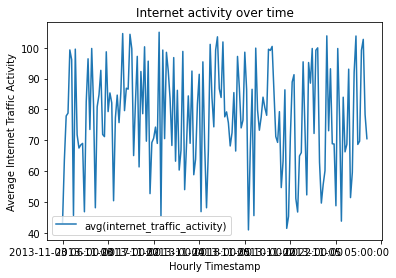

CPU times: user 693 ms, sys: 80.9 ms, total: 774 ms
Wall time: 5.98 s


In [37]:
%%time
plot(data_pq)

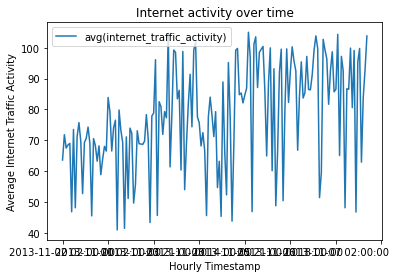

CPU times: user 769 ms, sys: 75.2 ms, total: 845 ms
Wall time: 50.1 s


In [38]:
%%time
plot(data_csv)

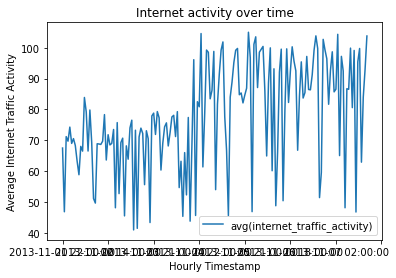

CPU times: user 538 ms, sys: 159 ms, total: 697 ms
Wall time: 17min 23s


In [20]:
%%time
plot(data1)

In [ ]:
# Possible TODOs
# configure spark to have more workers and compare again
# save data on hbase or other db and compare write time and justify

### To be moved to other file

To measure the performance of the autoencoder model, we can use the reconstruction error as a metric. The reconstruction error is typically measured as the mean squared error (MSE) between the original input and its reconstruction. A lower reconstruction error indicates better performance.

To evaluate the model’s performance, we can calculate the MSE between the original input data X_train and its corresponding reconstructed data reconstructed_data

In [ ]:
mse = tf.keras.losses.mean_squared_error(X_train, reconstructed_data)

In [ ]:
# Plotting anomalies versus normal items
plt.scatter(X_train['Timestamp'], X_train['SMS_in_activity'], label='Normal')
plt.scatter(anomalies['Timestamp'], anomalies['SMS_in_activity'], color='red', label='Anomaly')
plt.xlabel('Timestamp')
plt.ylabel('SMS-in Activity')
plt.title('Anomalies Detected')
plt.legend()
plt.show()

In [ ]:
# Stop the Spark session
spark.stop()